In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import spconv.pytorch as spconv
import matplotlib.pyplot as plt
import mytools
import mymodels
from matplotlib import colors


In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# Load Heteroscedastic model
model_HSCDC = torch.load('../3D_Heteroscedastic_Convnet_models/3D_HSCDC_CNN_subM-256.pt').to(device)


Using cuda device


In [3]:
# Function to get prediction for a given test case
def get_pred(Energy=50,Diff='H'):
    
    # Read pandas dataframe with all information about sparse testing tensors
    st_info = pd.read_pickle('/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/sparse_tensor_info.pk')

    # Make custom dataset
    MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_testing_tensors_'+str(Energy)+'keV_'+Diff+'diff/', st_info=st_info)

    # Create DataLoader
    batch_size = 64
    test_dataloader = DataLoader(MyDataset, batch_size=batch_size, shuffle=True)

    # Print tensor shapes
    for X_plot, y_plot, offset_plot in test_dataloader:
        print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
        print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
        print("Offsets: ", offset_plot.shape)
        break

    #Record shape of voxel grid
    grid_shape = X_plot.shape[1:4]
    print("Voxel grid shape: " , grid_shape)
    
    # Obtain predictions and Labels
    v_pred_HSCDC, K_pred_HSCDC, v_true_HSCDC, off_true_HSCDC = mytools.test_HSCDC(test_dataloader,model_HSCDC,device)
    
    return  v_pred_HSCDC, K_pred_HSCDC, v_true_HSCDC, off_true_HSCDC
    

In [4]:
# Get predictions for different test cases
v_pred_HSCDC_50keV_H, K_pred_HSCDC_50keV_H, v_true_HSCDC_50keV_H, off_true_HSCDC_50keV_H = get_pred(Energy=50,Diff='H')
v_pred_HSCDC_50keV_L, K_pred_HSCDC_50keV_L, v_true_HSCDC_50keV_L, off_true_HSCDC_50keV_L = get_pred(Energy=50,Diff='L')
v_pred_HSCDC_40keV_H, K_pred_HSCDC_40keV_H, v_true_HSCDC_40keV_H, off_true_HSCDC_40keV_H = get_pred(Energy=40,Diff='H')
v_pred_HSCDC_40keV_L, K_pred_HSCDC_40keV_L, v_true_HSCDC_40keV_L, off_true_HSCDC_40keV_L = get_pred(Energy=40,Diff='L')


Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])
Voxel grid shape:  torch.Size([120, 120, 120])
Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])
Voxel grid shape:  torch.Size([120, 120, 120])
Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])
Voxel grid shape:  torch.Size([120, 120, 120])
Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])
Voxel grid shape:  torch.Size([120, 120, 120])


# Test Kappa for a single test case

In [5]:
x = K_pred_HSCDC_50keV_H.flatten().numpy()
y = torch.arccos(mytools.CS(v_pred_HSCDC_50keV_H,v_true_HSCDC_50keV_H)).numpy()

In [6]:
# Plot correleation coefficient matrix
np.corrcoef(np.asarray([x,y]))

array([[ 1.        , -0.27538985],
       [-0.27538985,  1.        ]])

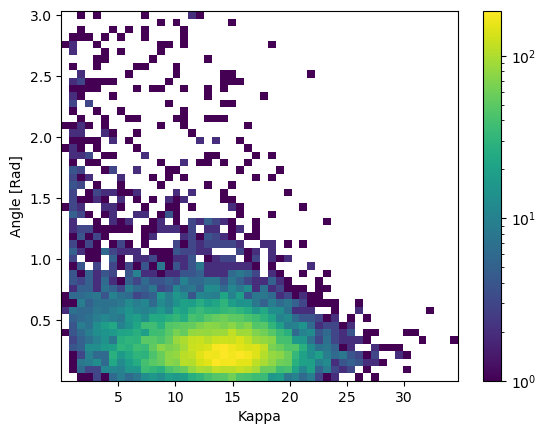

In [7]:
plt.hist2d(x, y, bins=(50, 50), norm = colors.LogNorm())
plt.xlabel("Kappa")
plt.ylabel("Angle [Rad]")
plt.colorbar()
plt.show()


# Test Kappa for a all test cases

In [8]:
x_50H = K_pred_HSCDC_50keV_H.flatten().numpy()
y_50H = torch.arccos(mytools.CS(v_pred_HSCDC_50keV_H,v_true_HSCDC_50keV_H)).numpy()

x_50L = K_pred_HSCDC_50keV_L.flatten().numpy()
y_50L = torch.arccos(mytools.CS(v_pred_HSCDC_50keV_L,v_true_HSCDC_50keV_L)).numpy()

x_40H = K_pred_HSCDC_40keV_H.flatten().numpy()
y_40H = torch.arccos(mytools.CS(v_pred_HSCDC_40keV_H,v_true_HSCDC_40keV_H)).numpy()

x_40L = K_pred_HSCDC_40keV_L.flatten().numpy()
y_40L = torch.arccos(mytools.CS(v_pred_HSCDC_40keV_L,v_true_HSCDC_40keV_L)).numpy()

In [9]:
xs = np.concatenate((x_50H,x_50L,x_40H,x_40L))
ys = np.concatenate((y_50H,y_50L,y_40H,y_40L))


In [10]:
# Plot correleation coefficient matrix
np.corrcoef(np.asarray([xs,ys]))

array([[ 1.        , -0.29967433],
       [-0.29967433,  1.        ]])

/tmp/ipykernel_209648/2009494946.py:8: RuntimeWarning: invalid value encountered in scalar divide
  mean_vals += [np.dot(h[i,:],y_centers)/np.sum(h[i,:])]


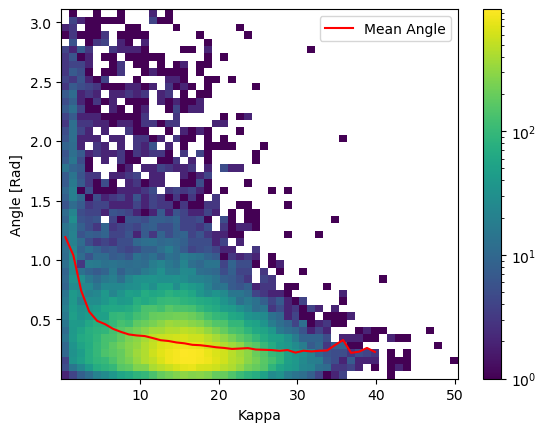

In [11]:
h, x_edges, y_edges, image = plt.hist2d(xs, ys, bins=(50, 50), norm = colors.LogNorm())

y_centers = (y_edges[:-1]+y_edges[1:])/2.0
x_centers = (x_edges[:-1]+x_edges[1:])/2.0

mean_vals = []
for i in range(len(x_centers)):
    mean_vals += [np.dot(h[i,:],y_centers)/np.sum(h[i,:])]
    
plt.plot(x_centers[:40],mean_vals[:40],color='r',label="Mean Angle")
plt.legend()
plt.xlabel("Kappa")
plt.ylabel("Angle [Rad]")
plt.colorbar()
plt.show()
